In [27]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import math
from d2l import tensorflow as d2l


# 6.1 Gradient Descent
:label:`sec_gd`

In this section we are going to introduce the basic concepts underlying *gradient descent*.
Although it is rarely used directly in deep learning, an understanding of gradient descent is key to understanding stochastic gradient descent algorithms. 
For instance, the optimization problem might diverge due to an overly large learning rate. This phenomenon can already be seen in gradient descent. Likewise, preconditioning is a common technique in gradient descent and carries over to more advanced algorithms.
Let us start with a simple special case.


## 6.1.1 One-Dimensional Gradient Descent

Gradient descent in one dimension is an excellent example to explain why the gradient descent algorithm may reduce the value of the objective function. Consider some continuously differentiable real-valued function $f: \mathbb{R} \rightarrow \mathbb{R}$. Using a Taylor expansion we obtain

$$f(x + \epsilon) = f(x) + \epsilon f'(x) + \mathcal{O}(\epsilon^2).$$
:eqlabel:`gd-taylor`

That is, in first-order approximation $f(x+\epsilon)$ is given by the function value $f(x)$ and the first derivative $f'(x)$ at $x$. It is not unreasonable to assume that for small $\epsilon$ moving in the direction of the negative gradient will decrease $f$. To keep things simple we pick a fixed step size $\eta > 0$ and choose $\epsilon = -\eta f'(x)$. Plugging this into the Taylor expansion above we get

$$f(x - \eta f'(x)) = f(x) - \eta f'^2(x) + \mathcal{O}(\eta^2 f'^2(x)).$$
:eqlabel:`gd-taylor-2`

If the derivative $f'(x) \neq 0$ does not vanish we make progress since $\eta f'^2(x)>0$. Moreover, we can always choose $\eta$ small enough for the higher-order terms to become irrelevant. Hence we arrive at

$$f(x - \eta f'(x)) \lessapprox f(x).$$

This means that, if we use

$$x \leftarrow x - \eta f'(x)$$

to iterate $x$, the value of function $f(x)$ might decline. Therefore, in gradient descent we first choose an initial value $x$ and a constant $\eta > 0$ and then use them to continuously iterate $x$ until the stop condition is reached, for example, when the magnitude of the gradient $|f'(x)|$ is small enough or the number of iterations has reached a certain value.

For simplicity we choose the objective function $f(x)=x^2$ to illustrate how to implement gradient descent. Although we know that $x=0$ is the solution to minimize $f(x)$, we still use this simple function to observe how $x$ changes.


In [3]:
def f(x):  # Objective function
    return x**2

def f_grad(x):  # Gradient (derivative) of the objective function
    return 2 * x

def gd(eta, f_grad):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x)
        results.append(float(x))
    print(f'epoch 10, x: {x:f}')
    return results

In [4]:
results = gd(0.2, f_grad)

epoch 10, x: 0.060466


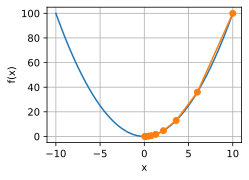

In [5]:
def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = tf.range(-n, n, 0.01)
    d2l.set_figsize()
    d2l.plot([f_line, results],
             [[f(x) for x in f_line], [f(x) for x in results]], 'x', 'f(x)',
             fmts=['-', '-o'])

show_trace(results, f)

### 6.1.2 Learning Rate

The learning rate $\eta$ can be set by the algorithm designer. If we use a learning rate that is too small, it will cause $x$ to update very slowly, requiring more iterations to get a better solution. To show what happens in such a case, consider the progress in the same optimization problem for $\eta = 0.05$. As we can see, even after 10 steps we are still very far from the optimal solution.


epoch 10, x: 8.170728


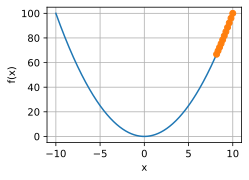

In [6]:
show_trace(gd(0.01, f_grad), f)

epoch 10, x: 3.486784


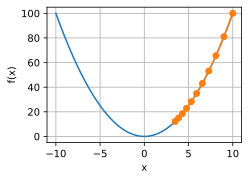

In [7]:
show_trace(gd(0.05, f_grad), f)

epoch 10, x: 61.917364


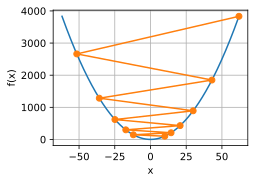

In [8]:
show_trace(gd(1.1, f_grad), f)

### 6.1.3 Local Minima

To illustrate what happens for nonconvex functions consider the case of $f(x) = x \cdot \cos(cx)$ for some constant $c$. This function has infinitely many local minima. Depending on our choice of the learning rate and depending on how well conditioned the problem is, we may end up with one of many solutions. The example below illustrates how an (unrealistically) high learning rate will lead to a poor local minimum.


epoch 10, x: -1.528165


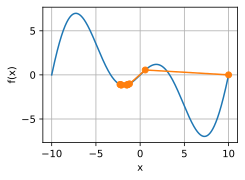

In [9]:
c = tf.constant(0.15 * np.pi)

def f(x):  # Objective function
    return x * tf.cos(c * x)

def f_grad(x):  # Gradient of the objective function
    return tf.cos(c * x) - c * x * tf.sin(c * x)

show_trace(gd(2, f_grad), f)

## 6.2 Multivariate Gradient Descent

Now that we have a better intuition of the univariate case, let us consider the situation where $\mathbf{x} = [x_1, x_2, \ldots, x_d]^\top$. That is, the objective function $f: \mathbb{R}^d \to \mathbb{R}$ maps vectors into scalars. Correspondingly its gradient is multivariate, too. It is a vector consisting of $d$ partial derivatives:

$$\nabla f(\mathbf{x}) = \bigg[\frac{\partial f(\mathbf{x})}{\partial x_1}, \frac{\partial f(\mathbf{x})}{\partial x_2}, \ldots, \frac{\partial f(\mathbf{x})}{\partial x_d}\bigg]^\top.$$

Each partial derivative element $\partial f(\mathbf{x})/\partial x_i$ in the gradient indicates the rate of change of $f$ at $\mathbf{x}$ with respect to the input $x_i$. As before in the univariate case we can use the corresponding Taylor approximation for multivariate functions to get some idea of what we should do. In particular, we have that

$$f(\mathbf{x} + \boldsymbol{\epsilon}) = f(\mathbf{x}) + \mathbf{\boldsymbol{\epsilon}}^\top \nabla f(\mathbf{x}) + \mathcal{O}(\|\boldsymbol{\epsilon}\|^2).$$
:eqlabel:`gd-multi-taylor`

In other words, up to second-order terms in $\boldsymbol{\epsilon}$ the direction of steepest descent is given by the negative gradient $-\nabla f(\mathbf{x})$. Choosing a suitable learning rate $\eta > 0$ yields the prototypical gradient descent algorithm:

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f(\mathbf{x}).$$

To see how the algorithm behaves in practice let us construct an objective function $f(\mathbf{x})=x_1^2+2x_2^2$ with a two-dimensional vector $\mathbf{x} = [x_1, x_2]^\top$ as input and a scalar as output. The gradient is given by $\nabla f(\mathbf{x}) = [2x_1, 4x_2]^\top$. We will observe the trajectory of $\mathbf{x}$ by gradient descent from the initial position $[-5, -2]$. 

To begin with, we need two more helper functions. The first uses an update function and applies it 20 times to the initial value. The second helper visualizes the trajectory of $\mathbf{x}$.


In [10]:
def train_2d(trainer, steps=20, f_grad=None):  #@save
    """Optimize a 2D objective function with a customized trainer."""
    # `s1` and `s2` are internal state variables that will be used later
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

def show_trace_2d(f, results):  #@save
    """Show the trace of 2D variables during optimization."""
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = tf.meshgrid(tf.range(-5.5, 1.0, 0.1), tf.range(-3.0, 1.0, 0.1))
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

epoch 20, x1: -0.057646, x2: -0.000073


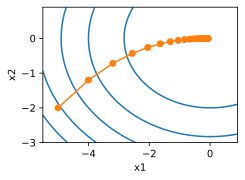

In [11]:
def f_2d(x1, x2):  # Objective function
    return x1**2 + 2 * x2**2

def f_2d_grad(x1, x2):  # Gradient of the objective function
    return (2 * x1, 4 * x2)

def gd_2d(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)

eta = 0.1
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))

## 6.3 Adaptive Methods

As we could see in :numref:`subsec_gd-learningrate`, getting the learning rate $\eta$ "just right" is tricky. If we pick it too small, we make little progress. If we pick it too large, the solution oscillates and in the worst case it might even diverge. What if we could determine $\eta$ automatically or get rid of having to select a learning rate at all? 
Second-order methods that look not only at the value and gradient of the objective function
but also at its *curvature* can help in this case. While these methods cannot be applied to deep learning directly due to the computational cost, they provide useful intuition into how to design advanced optimization algorithms that mimic many of the desirable properties of the algorithms outlined below.


### 6.3.1 Newton's Method

Reviewing the Taylor expansion of some function $f: \mathbb{R}^d \rightarrow \mathbb{R}$ there is no need to stop after the first term. In fact, we can write it as

$$f(\mathbf{x} + \boldsymbol{\epsilon}) = f(\mathbf{x}) + \boldsymbol{\epsilon}^\top \nabla f(\mathbf{x}) + \frac{1}{2} \boldsymbol{\epsilon}^\top \nabla^2 f(\mathbf{x}) \boldsymbol{\epsilon} + \mathcal{O}(\|\boldsymbol{\epsilon}\|^3).$$
:eqlabel:`gd-hot-taylor`

To avoid cumbersome notation we define $\mathbf{H} \stackrel{\mathrm{def}}{=} \nabla^2 f(\mathbf{x})$ to be the Hessian of $f$, which is a $d \times d$ matrix. For small $d$ and simple problems $\mathbf{H}$ is easy to compute. For deep neural networks, on the other hand, $\mathbf{H}$ may be prohibitively large, due to the cost of storing $\mathcal{O}(d^2)$ entries. Furthermore it may be too expensive to compute via backpropagation. For now let us ignore such considerations and look at what algorithm we would get.

After all, the minimum of $f$ satisfies $\nabla f = 0$. 
Following calculus rules in :numref:`subsec_calculus-grad`,
by taking derivatives of :eqref:`gd-hot-taylor` with regard to $\boldsymbol{\epsilon}$ and ignoring higher-order terms we arrive at

$$\nabla f(\mathbf{x}) + \mathbf{H} \boldsymbol{\epsilon} = 0 \text{ and hence }
\boldsymbol{\epsilon} = -\mathbf{H}^{-1} \nabla f(\mathbf{x}).$$

That is, we need to invert the Hessian $\mathbf{H}$ as part of the optimization problem.

As a simple example, for $f(x) = \frac{1}{2} x^2$ we have $\nabla f(x) = x$ and $\mathbf{H} = 1$. Hence for any $x$ we obtain $\epsilon = -x$. In other words, a *single* step is sufficient to converge perfectly without the need for any adjustment! Alas, we got a bit lucky here: the Taylor expansion was exact since $f(x+\epsilon)= \frac{1}{2} x^2 + \epsilon x + \frac{1}{2} \epsilon^2$. 

Let us see what happens in other problems.
Given a convex hyperbolic cosine function $f(x) = \cosh(cx)$ for some constant $c$, we can see that
the global minimum at $x=0$ is reached
after a few iterations.


epoch 10, x: tf.Tensor(0.0, shape=(), dtype=float32)


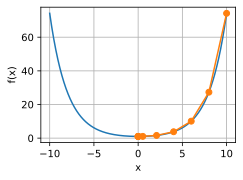

In [12]:
c = tf.constant(0.5)

def f(x):  # Objective function
    return tf.cosh(c * x)

def f_grad(x):  # Gradient of the objective function
    return c * tf.sinh(c * x)

def f_hess(x):  # Hessian of the objective function
    return c**2 * tf.cosh(c * x)

def newton(eta=1):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x) / f_hess(x)
        results.append(float(x))
    print('epoch 10, x:', x)
    return results

show_trace(newton(), f)

- Now let us consider a *nonconvex* function, such as $f(x) = x \cos(c x)$ for some constant $c$. After all, note that in Newton's method we end up dividing by the Hessian. This means that if the second derivative is **negative** we may walk into the direction of *increasing* the value of $f$. That is a fatal flaw of the algorithm. Let us see what happens in practice.


epoch 10, x: tf.Tensor(26.834133, shape=(), dtype=float32)


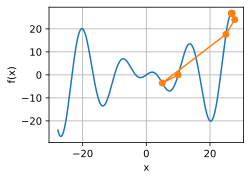

In [13]:
c = tf.constant(0.15 * np.pi)

def f(x):  # Objective function
    return x * tf.cos(c * x)

def f_grad(x):  # Gradient of the objective function
    return tf.cos(c * x) - c * x * tf.sin(c * x)

def f_hess(x):  # Hessian of the objective function
    return -2 * c * tf.sin(c * x) - x * c**2 * tf.cos(c * x)

show_trace(newton(), f)

- This went spectacularly wrong. How can we fix it? One way would be to "fix" the Hessian by taking its absolute value instead. Another strategy is to bring back the learning rate. This seems to defeat the purpose, but not quite. Having second-order information allows us to be cautious whenever the curvature is large and to take longer steps whenever the objective function is flatter. Let us see how this works with a slightly smaller learning rate, say $\eta = 0.5$. As we can see, we have quite an efficient algorithm.


epoch 10, x: tf.Tensor(7.26986, shape=(), dtype=float32)


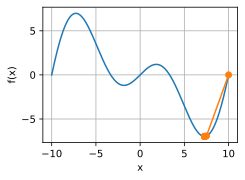

In [15]:
show_trace(newton(0.5), f)

## 6.4 Stochastic Gradient Updates

In deep learning, the objective function is usually the average of the loss functions for each example in the training dataset. 
Given a training dataset of $n$ examples,
we assume that $f_i(\mathbf{x})$ is the loss function 
with respect to the training example of index $i$,
where $\mathbf{x}$ is the parameter vector.
Then we arrive at the objective function

$$f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\mathbf{x}).$$

The gradient of the objective function at $\mathbf{x}$ is computed as

$$\nabla f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}).$$

If gradient descent is used, the computational cost for each independent variable iteration is $\mathcal{O}(n)$, which grows linearly with $n$. Therefore, when the  training dataset is larger, the cost of gradient descent for each iteration will be higher.

Stochastic gradient descent (SGD) reduces computational cost at each iteration. At each iteration of stochastic gradient descent, we uniformly sample an index $i\in\{1,\ldots, n\}$ for data examples at random, and compute the gradient $\nabla f_i(\mathbf{x})$ to update $\mathbf{x}$:

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f_i(\mathbf{x}),$$

where $\eta$ is the learning rate. We can see that the computational cost for each iteration drops from $\mathcal{O}(n)$ of the gradient descent to the constant $\mathcal{O}(1)$. Moreover, we want to emphasize that the stochastic gradient $\nabla f_i(\mathbf{x})$ is an unbiased estimate of the full gradient $\nabla f(\mathbf{x})$ because

$$\mathbb{E}_i \nabla f_i(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}) = \nabla f(\mathbf{x}).$$

This means that, on average, the stochastic gradient is a good estimate of the gradient.

Now, we will compare it with gradient descent by adding random noise with a mean of 0 and a variance of 1 to the gradient to simulate a stochastic gradient descent.


In [24]:
def f(x1, x2):  # Objective function
    return x1**2 + 2 * x2**2

def f_grad(x1, x2):  # Gradient of the objective function
    return 2 * x1, 4 * x2

def sgd(x1, x2, s1, s2):
    g1, g2 = f_grad(x1, x2)
    # Simulate noisy gradient
    g1 += tf.random.normal([1], 0.0, 1)
    g2 += tf.random.normal([1], 0.0, 1)
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

def constant_lr():
    return 1

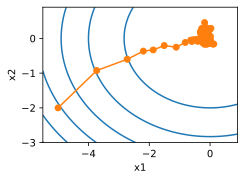

In [25]:


eta = 0.1
lr = constant_lr  # Constant learning rate
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50))

As we can see, the trajectory of the variables in the stochastic gradient descent is much more noisy than the one we observed in gradient descent in :numref:`sec_gd`. This is due to the stochastic nature of the gradient. That is, even when we arrive near the minimum, we are still subject to the uncertainty injected by the instantaneous gradient via $\eta \nabla f_i(\mathbf{x})$. Even after 50 steps the quality is still not so good. Even worse, it will not improve after additional steps (we encourage you to experiment with a larger number of steps to confirm this). This leaves us with the only alternative: change the learning rate $\eta$. However, if we pick this too small, we will not make any meaningful progress initially. On the other hand, if we pick it too large, we will not get a good solution, as seen above. The only way to resolve these conflicting goals is to reduce the learning rate *dynamically* as optimization progresses.

This is also the reason for adding a learning rate function `lr` into the `sgd` step function. In the example above any functionality for learning rate scheduling lies dormant as we set the associated `lr` function to be constant.

## 6.4.1 Dynamic Learning Rate

Replacing $\eta$ with a time-dependent learning rate $\eta(t)$ adds to the complexity of controlling convergence of an optimization algorithm. In particular, we need to figure out how rapidly $\eta$ should decay. If it is too quick, we will stop optimizing prematurely. If we decrease it too slowly, we waste too much time on optimization. The following are a few basic strategies that are used in adjusting $\eta$ over time (we will discuss more advanced strategies later):

$$
\begin{aligned}
    \eta(t) & = \eta_i \text{ if } t_i \leq t \leq t_{i+1}  && \text{piecewise constant} \\
    \eta(t) & = \eta_0 \cdot e^{-\lambda t} && \text{exponential decay} \\
    \eta(t) & = \eta_0 \cdot (\beta t + 1)^{-\alpha} && \text{polynomial decay}
\end{aligned}
$$

In the first *piecewise constant* scenario we decrease the learning rate, e.g., whenever progress in optimization stalls. This is a common strategy for training deep networks. Alternatively we could decrease it much more aggressively by an *exponential decay*. Unfortunately this often leads to premature stopping before the algorithm has converged. A popular choice is *polynomial decay* with $\alpha = 0.5$. In the case of convex optimization there are a number of proofs that show that this rate is well behaved. 

Let us see what the exponential decay looks like in practice.


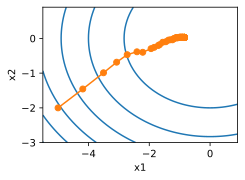

In [28]:
def exponential_lr():
    # Global variable that is defined outside this function and updated inside
    global t
    t += 1
    return math.exp(-0.1 * t)

t = 1
lr = exponential_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=1000))

- As expected, the variance in the parameters is significantly reduced. However, this comes at the expense of failing to converge to the optimal solution $\mathbf{x} = (0, 0)$. Even after 1000 iteration steps are we are still very far away from the optimal solution. Indeed, the algorithm fails to converge at all. On the other hand, if we use a polynomial decay where the learning rate decays with the inverse square root of the number of steps, convergence gets better after only 50 steps.


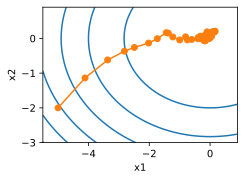

In [29]:
def polynomial_lr():
    # Global variable that is defined outside this function and updated inside
    global t
    t += 1
    return (1 + 0.1 * t)**(-0.5)

t = 1
lr = polynomial_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50))